# New York Air Bnb: case study

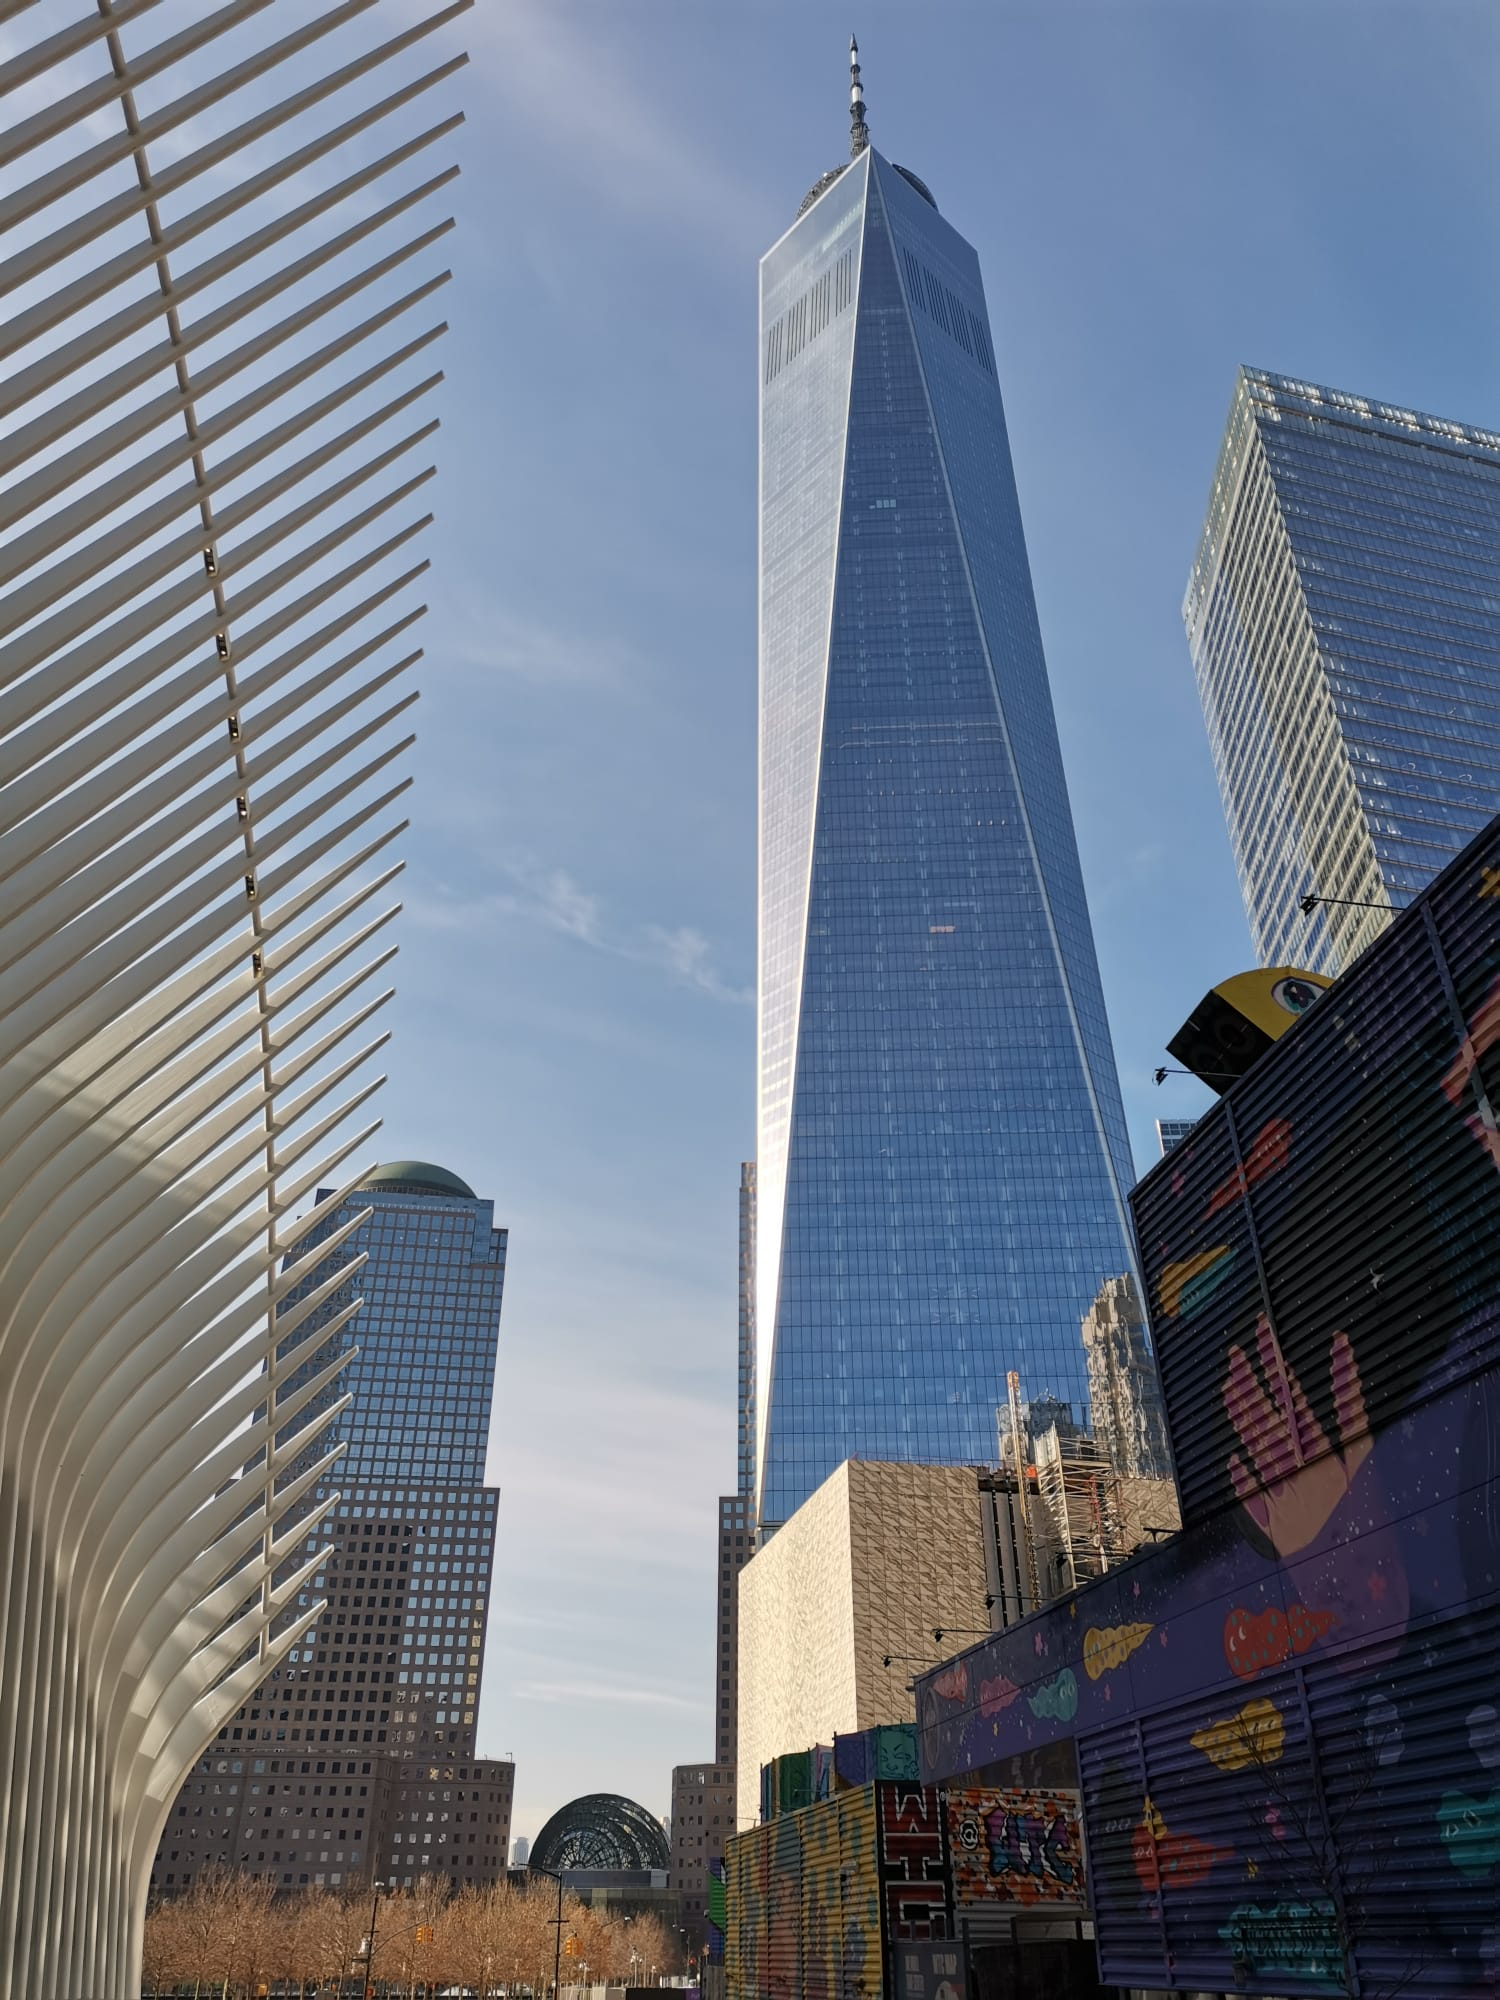

In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [48]:
#create dataframes from csv and xlsx
#

df_prices=pd.read_csv("airbnb_price.csv")
df_review=pd.read_csv("airbnb_last_review.csv")
df_room=pd.read_excel("airbnb_room_type.xlsx", sheet_name="airbnb_room_type")

#store the dataframe in a list to use the same function with a for cycle
dataframes=[df_prices, df_review, df_room]

## Data cleaning 

Analysis of each Dataset in order to see each dataset structure

In [49]:
#show datasets informations with the info function
for df in dataframes:
   df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   price        25209 non-null  object
 2   nbhood_full  25209 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0    listing_id  25209 non-null  int64 
 1   host_name    25201 non-null  object
 2   last_review  25209 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   description  25199 non-null  objec

We can notice that the first column name of the review dataset presents a leading space so, first of all, let's fix this problem using the rename problem

In [50]:
#rename the column removing the leading space 
df_review=df_review.rename(columns={' listing_id':'listing_id'})
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   listing_id   25209 non-null  int64 
 1   host_name    25201 non-null  object
 2   last_review  25209 non-null  object
dtypes: int64(1), object(2)
memory usage: 591.0+ KB


Now we can explore the first rows of the datasets with the function head to see if we can clean anything else. In fact, above we notice that both price and last_review columns are shown as an object time instead of a float and a datetime.

In [51]:
#show the first 5 rows of each dataset with the head function
for df in dataframes:
    print(df.head())

   listing_id        price                nbhood_full
0        2595  225 dollars         Manhattan, Midtown
1        3831   89 dollars     Brooklyn, Clinton Hill
2        5099  200 dollars     Manhattan, Murray Hill
3        5178   79 dollars  Manhattan, Hell's Kitchen
4        5238  150 dollars       Manhattan, Chinatown
    listing_id    host_name   last_review
0         2595     Jennifer   May 21 2019
1         3831  LisaRoxanne  July 05 2019
2         5099        Chris  June 22 2019
3         5178     Shunichi  June 24 2019
4         5238          Ben  June 09 2019
   listing_id                                description        room_type
0        2595                      Skylit Midtown Castle  Entire home/apt
1        3831            Cozy Entire Floor of Brownstone  Entire home/apt
2        5099  Large Cozy 1 BR Apartment In Midtown East  Entire home/apt
3        5178            Large Furnished Room Near B'way     private room
4        5238         Cute & Cozy Lower East Side 1 bd

We can remove the dollars from price columns and set the correct types. Moreover, the room type column in the room_type dataset presents some words capitalized and some words not capitalized so we can investigate to see all the values in this column. 

In [52]:
#remove dollars from price data and set the type as float
df_prices["price"]=df_prices["price"].str.rstrip(' dollars')
df_prices["price"]=df_prices["price"].astype(float)
df_prices.head()

,listing_id,price,nbhood_full
0,2595,225.0,"Manhattan, Midtown"
1,3831,89.0,"Brooklyn, Clinton Hill"
2,5099,200.0,"Manhattan, Murray Hill"
3,5178,79.0,"Manhattan, Hell's Kitchen"
4,5238,150.0,"Manhattan, Chinatown"


In [53]:
#set last review column as a datetime type
df_review["last_review"]=pd.to_datetime(df_review["last_review"])
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25209 entries, 0 to 25208
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   listing_id   25209 non-null  int64         
 1   host_name    25201 non-null  object        
 2   last_review  25209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 591.0+ KB


In [54]:
#show the differents values of the room type column 
df_room["room_type"].unique()

array(['Entire home/apt', 'private room', 'Private room',
       'entire home/apt', 'PRIVATE ROOM', 'shared room',
       'ENTIRE HOME/APT', 'Shared room', 'SHARED ROOM'], dtype=object)

Basically there are 3 different entries: shared room, entire home/apt and private room that differ in the capitalization. So we can fix this problem using the capitalize function to capitalize only the first letter.

In [55]:
#capitalize the room type column with the capitalize function
df_room["room_type"]=df_room["room_type"].str.capitalize()
df_room["room_type"].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

First of all we can calculate the mean. Before that we can check if there are some outliers in our price dataset that could affect the average, value using the describe method.

In [56]:
df_prices["price"].describe()


count    25209.000000
mean       141.777936
std        147.349137
min          0.000000
25%         69.000000
50%        105.000000
75%        175.000000
max       7500.000000
Name: price, dtype: float64

There are some free rooms that could affect the mean calculation, so we can remove from our dataset. The maximum value is 7500 dollars/night. However, it could be normal since New York is expensive. So let's see the 10 biggest value in the price column to see if there are any values similar.

In [57]:
#Extract the first 10 value of the sorted dataset with the method head
df_prices["price"].sort_values(ascending=False).head(10)

23916    7500.0
22085    5100.0
18430    5000.0
21731    3613.0
12508    3000.0
24432    2995.0
13528    2990.0
21838    2600.0
1234     2500.0
23601    2500.0
Name: price, dtype: float64

In [58]:
#deleting rows using the drop function
df_prices.drop(df_prices.index[df_prices["price"]==0], inplace=True)


## Average price calculation

It's now possible calculate the average price per night

In [59]:
average_price=round(df_prices["price"].mean(),2)
print("The average AirBnb price per night of New York is: $", average_price)

The average AirBnb price per night of New York is: $ 141.82


## Average price by room type

To be more accurate we can calculate the average price for each different room type (Entire apt, Private room or Shared Room). The information about the room type are inside the room type dataframe. So we can use the merge function to show the information of the price and the room type together. We are interested only in the rows that have the price so we'll use a left join. 

In [60]:
#left join with the merge function on the columnd listing id
df_price_room=df_prices.merge(df_room, how="left", on="listing_id")
df_price_room.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25202 entries, 0 to 25201
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   listing_id   25202 non-null  int64  
 1   price        25202 non-null  float64
 2   nbhood_full  25202 non-null  object 
 3   description  25192 non-null  object 
 4   room_type    25202 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In the new dataset there are some null value in the description column but it's not a big deal because we need the information of the room_type column. So we can group by the room_type in order to obtain an more accurate average. 

In [61]:
df_NyAirBnb=df_price_room.groupby("room_type", as_index=False)["price"].mean().round(2)
df_NyAirBnb

,room_type,price
0,Entire home/apt,197.17
1,Private room,81.67
2,Shared room,53.65


In [62]:
for room in df_NyAirBnb["room_type"]:
    print("The average cost of {} is $ {}".format(room, df_NyAirBnb.loc[df_NyAirBnb["room_type"]==room]["price"].values[0]))

The average cost of Entire home/apt is $ 197.17
The average cost of Private room is $ 81.67
The average cost of Shared room is $ 53.65


## Calculation of district average AirBnb price in new york

We can now extent the analysis to the 5 New York district (Manhattan, Queens, Brooklyn, Bronx and Staten Island) and calculate the average price per discrict using the column "nbhood_full". We noticed above that this column cointains both the district name and the neighborhood name separated by a comma. So we'll use the split function to obtain to column one for each

In [63]:
#Splitting the nbhood column in discrict and nieghborhood
df_price_room[['district', 'neighborhood']]=df_price_room['nbhood_full'].str.split(",", expand=True, n=1)
df_price_room


,listing_id,price,nbhood_full,description,room_type,district,neighborhood
0,2595,225.0,"Manhattan, Midtown",Skylit Midtown Castle,Entire home/apt,Manhattan,Midtown
1,3831,89.0,"Brooklyn, Clinton Hill",Cozy Entire Floor of Brownstone,Entire home/apt,Brooklyn,Clinton Hill
2,5099,200.0,"Manhattan, Murray Hill",Large Cozy 1 BR Apartment In Midtown East,Entire home/apt,Manhattan,Murray Hill
3,5178,79.0,"Manhattan, Hell's Kitchen",Large Furnished Room Near B'way,Private room,Manhattan,Hell's Kitchen
4,5238,150.0,"Manhattan, Chinatown",Cute & Cozy Lower East Side 1 bdrm,Entire home/apt,Manhattan,Chinatown
...,...,...,...,...,...,...,...
25197,36425863,129.0,"Manhattan, Upper East Side",Lovely Privet Bedroom with Privet Restroom,Private room,Manhattan,Upper East Side
25198,36427429,45.0,"Queens, Flushing",No.2 with queen size bed,Private room,Queens,Flushing
25199,36438336,235.0,"Staten Island, Great Kills",Seas The Moment,Private room,Staten Island,Great Kills
25200,36442252,100.0,"Bronx, Mott Haven",1B-1B apartment near by Metro,Entire home/apt,Bronx,Mott Haven


In [64]:
#Calculate of the average AirBnb price/night by district and room type
df_DistrictAirBnb=df_price_room.groupby(["room_type","district"], as_index=False)["price"].mean().round(2)
df_DistrictAirBnb

,room_type,district,price
0,Entire home/apt,Bronx,120.52
1,Entire home/apt,Brooklyn,169.90
2,Entire home/apt,Manhattan,238.02
3,Entire home/apt,Queens,140.93
4,Entire home/apt,Staten Island,116.77
5,Private room,Bronx,56.29
6,Private room,Brooklyn,72.69
7,Private room,Manhattan,105.70
8,Private room,Queens,63.74
9,Private room,Staten Island,56.06


## Private rental market Vs Airbnb

We can now compare these prices with the New York City rental prices. According to Zumper these are the medium prices for month for a studio from 2019 to now:

In [65]:
#reading New York rent data from the Excel
df_NyRent=pd.read_excel("NyRentZumper.xlsx", sheet_name="New York")
df_NyRent["Month Year"]=pd.to_datetime(df_NyRent["Month Year"])
df_NyRent.head()

,Month Year,Average Rent
0,2023-01-01,"$3,200"
1,2022-12-01,"$3,243"
2,2022-11-01,"$3,322"
3,2022-10-01,"$3,306"
4,2022-09-01,"$3,350"


In [66]:
#formatting data
df_NyRent["Year"]=pd.DatetimeIndex(df_NyRent["Month Year"]).year
df_NyRent["Month"]=pd.DatetimeIndex(df_NyRent["Month Year"]).month
df_NyRent.drop(columns="Month Year", inplace=True)
df_NyRent["Average Rent"]=df_NyRent["Average Rent"].str.replace('$', "", regex=True)
df_NyRent["Average Rent"]=df_NyRent["Average Rent"].str.replace(',', "")
df_NyRent["Average Rent"]=df_NyRent["Average Rent"].astype(float)
df_NyRent.head()

,Average Rent,Year,Month
0,3200.0,2023,1
1,3243.0,2022,12
2,3322.0,2022,11
3,3306.0,2022,10
4,3350.0,2022,9


In [67]:
#reading New York district rent data from the Excel
df_NyDistrictRent=pd.read_excel("NyRentZumper.xlsx", sheet_name="District")
df_NyDistrictRent["Month Year"]=pd.to_datetime(df_NyDistrictRent["Month Year"])
df_NyDistrictRent.head()

,Month Year,Average Rent,District
0,2023-01-01,"$3,966",Manhattan
1,2022-12-01,"$3,907",Manhattan
2,2022-11-01,"$3,949",Manhattan
3,2022-10-01,"$4,082",Manhattan
4,2022-09-01,"$4,185",Manhattan


In [68]:
#formatting data
df_NyDistrictRent["Year"]=pd.DatetimeIndex(df_NyDistrictRent["Month Year"]).year
df_NyDistrictRent["Month"]=pd.DatetimeIndex(df_NyDistrictRent["Month Year"]).month
df_NyDistrictRent.drop(columns="Month Year", inplace=True)
df_NyDistrictRent["Average Rent"]=df_NyDistrictRent["Average Rent"].str.replace('$', "", regex=True)
df_NyDistrictRent["Average Rent"]=df_NyDistrictRent["Average Rent"].str.replace(',', "")
df_NyDistrictRent["Average Rent"]=df_NyDistrictRent["Average Rent"].astype(float)
df_NyDistrictRent.head()

,Average Rent,District,Year,Month
0,3966.0,Manhattan,2023,1
1,3907.0,Manhattan,2022,12
2,3949.0,Manhattan,2022,11
3,4082.0,Manhattan,2022,10
4,4185.0,Manhattan,2022,9


We can now focus on 2019 data because our airbnb dataset focus on this particular year:

In [69]:
#group data for year and filter on 2019
df_NyRent=df_NyRent[df_NyRent["Year"]==2019].groupby(["Year"], as_index=False)["Average Rent"].mean().round(2)
df_NyRent

,Year,Average Rent
0,2019,2586.0


In [70]:
#group data for year and filter on 2019
df_NyDistrictRent=df_NyDistrictRent[df_NyDistrictRent["Year"]==2019].groupby(["Year", "District"], as_index=False)["Average Rent"].mean().round(2)
df_NyDistrictRent

,Year,District,Average Rent
0,2019,Bronx,1724.58
1,2019,Brooklyn,2929.17
2,2019,Manhattan,3160.92
3,2019,Queens,2079.83
4,2019,Staten Island,1859.75


In order to compare this data to our AirBnb data we need to transform the airbnb data from daily to monthly. We'll focus on the AirBnb related to Entire home/apt room type to compare them with studio

In [71]:
#Calculating monthly price
df_NyAirBnbApt=df_NyAirBnb[df_NyAirBnb["room_type"]=="Entire home/apt"].copy()
df_NyAirBnbApt["monthly price"]=round(df_NyAirBnbApt["price"]*365/12,2).round(2)
df_NyAirBnbApt

,room_type,price,monthly price
0,Entire home/apt,197.17,5997.25


In [72]:
#Calculating monthly price
df_DistrictAirBnBApt=df_DistrictAirBnb[df_DistrictAirBnb["room_type"]=="Entire home/apt"].copy()
df_DistrictAirBnBApt["monthly price"]=round(df_DistrictAirBnBApt["price"]*365/12,2).round(2)
df_DistrictAirBnBApt

,room_type,district,price,monthly price
0,Entire home/apt,Bronx,120.52,3665.82
1,Entire home/apt,Brooklyn,169.90,5167.79
2,Entire home/apt,Manhattan,238.02,7239.78
3,Entire home/apt,Queens,140.93,4286.62
4,Entire home/apt,Staten Island,116.77,3551.75


We can now compare the data in order to see which one is cheaper:

In [73]:
if (df_NyAirBnbApt.at[0,"monthly price"]>df_NyRent.at[0, "Average Rent"]):
    print("Private studio rent is cheaper than AirBnb. Private studio monthly rent is $ {} and Airbnb monthly price is $ {}. The difference is {}".format(df_NyRent.at[0, "Average Rent"],df_NyAirBnbApt.at[0,"monthly price"], df_NyAirBnbApt.at[0,"monthly price"]-df_NyRent.at[0, "Average Rent"] ))
else:
    print("AriBnb is cheaper than private studio rent. Private studio monthly rent is $ {} and Airbnb monthly price is $ {}. The difference is {}".format(df_NyRent.at[0, "Average Rent"],df_NyAirBnbApt.at[0,"monthly price"], -(df_NyAirBnbApt.at[0,"monthly price"]-df_NyRent.at[0, "Average Rent"]) ))

Private studio rent is cheaper than AirBnb. Private studio monthly rent is $ 2586.0 and Airbnb monthly price is $ 5997.25. The difference is 3411.25


In [74]:
for district in df_DistrictAirBnBApt["district"]:
    price_difference=(df_DistrictAirBnBApt.loc[df_DistrictAirBnBApt["district"]==district]["monthly price"].values[0]-df_NyDistrictRent.loc[df_NyDistrictRent["District"]==district]["Average Rent"].values[0]).round(2)
    if price_difference>0:
        print("Private studio rent in the {} district is cheaper than AirBnb. Private studio monthly rent is $ {} and Airbnb monthly price is $ {}. The difference is $ {}".format(district ,df_NyDistrictRent.loc[df_NyDistrictRent["District"]==district]["Average Rent"].values[0],df_DistrictAirBnBApt.loc[df_DistrictAirBnBApt["district"]==district]["monthly price"].values[0], price_difference ))
    else:
        print("AirBnb in the {} district is cheaper than private studio rent. Private studio monthly rent is $ {} and Airbnb monthly price is $ {}. The difference is $ {}".format(district ,df_NyDistrictRent.loc[df_NyDistrictRent["District"]==district]["Average Rent"].values[0],df_DistrictAirBnBApt.loc[df_DistrictAirBnBApt["district"]==district]["monthly price"].values[0], -price_difference ))

Private studio rent in the Bronx district is cheaper than AirBnb. Private studio monthly rent is $ 1724.58 and Airbnb monthly price is $ 3665.82. The difference is $ 1941.24
Private studio rent in the Brooklyn district is cheaper than AirBnb. Private studio monthly rent is $ 2929.17 and Airbnb monthly price is $ 5167.79. The difference is $ 2238.62
Private studio rent in the Manhattan district is cheaper than AirBnb. Private studio monthly rent is $ 3160.92 and Airbnb monthly price is $ 7239.78. The difference is $ 4078.86
Private studio rent in the Queens district is cheaper than AirBnb. Private studio monthly rent is $ 2079.83 and Airbnb monthly price is $ 4286.62. The difference is $ 2206.79
Private studio rent in the Staten Island district is cheaper than AirBnb. Private studio monthly rent is $ 1859.75 and Airbnb monthly price is $ 3551.75. The difference is $ 1692.0
